In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.notebook import tqdm
sns.set(style="whitegrid")


In [2]:
import os
import shutil

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/leukemia-dataset-1/ALL_IDB2/img'  # Change this if needed

# Define a writable output directory for the new folders
output_dir = '/kaggle/working/leukemia-dataset-separated'  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")


Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [4]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])



In [5]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = '/kaggle/working/leukemia-dataset-separated'

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")



Train size: 182, Val size: 39, Test size: 39


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        # Adaptive pooling across spatial dimensions
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Fully connected layers with reduction ratio
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention: average pooling
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        # Channel attention: max pooling
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        # Sum and apply sigmoid
        out = self.sigmoid(avg_out + max_out)
        return x * out  # Element-wise multiplication for channel attention

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # Spatial attention: convolution across spatial dimensions
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute max and average across channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        # Concatenate along the channel dimension and apply conv
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out  # Element-wise multiplication for spatial attention

class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention, then spatial attention
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ResNet50WithCBAM(nn.Module):
    def __init__(self, num_classes=2, pretrained=False):
        super(ResNet50WithCBAM, self).__init__()
        # Load ResNet50 model
        self.resnet = models.resnet50(pretrained=pretrained)
        
        # Apply CBAM after layer4, with input channels set to 2048
        self.resnet.layer4 = nn.Sequential(
            self.resnet.layer4,
            CBAMBlock(in_channels=2048)
        )

        # Modify the final fully connected layer for class prediction
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x
# Initialize the model for two classes
model = ResNet50WithCBAM(num_classes=2)

# Move model to the device (e.g., GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [8]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record loss and accuracy
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save the model with the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Usage example
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


Epoch 1/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6924 Acc: 0.6231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.9597 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5944 Acc: 0.6923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.9612 Acc: 0.5000

Epoch 3/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4940 Acc: 0.7577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2904 Acc: 0.9000

Epoch 4/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5042 Acc: 0.7692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.5587 Acc: 0.6885

Epoch 5/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4387 Acc: 0.7846


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4677 Acc: 0.6462

Epoch 6/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3742 Acc: 0.8462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2921 Acc: 0.8885

Epoch 7/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3384 Acc: 0.8615


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2693 Acc: 0.8731

Epoch 8/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3966 Acc: 0.8462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3146 Acc: 0.9000

Epoch 9/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3755 Acc: 0.8538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3111 Acc: 0.8654

Epoch 10/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3584 Acc: 0.8769


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.5018 Acc: 0.7846

Epoch 11/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2931 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6083 Acc: 0.7615

Epoch 12/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3137 Acc: 0.8577


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1637 Acc: 0.9462

Epoch 13/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3004 Acc: 0.8808


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1543 Acc: 0.9500

Epoch 14/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2940 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1720 Acc: 0.9462

Epoch 15/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2653 Acc: 0.8962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1678 Acc: 0.9462

Epoch 16/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2489 Acc: 0.8923


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1482 Acc: 0.9500

Epoch 17/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2431 Acc: 0.8962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1444 Acc: 0.9500

Epoch 18/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2337 Acc: 0.9192


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1370 Acc: 0.9423

Epoch 19/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2370 Acc: 0.8962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1269 Acc: 0.9577

Epoch 20/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2041 Acc: 0.9115


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1157 Acc: 0.9577

Epoch 21/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2499 Acc: 0.8885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1101 Acc: 0.9654

Epoch 22/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2696 Acc: 0.9077


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1116 Acc: 0.9654

Epoch 23/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2112 Acc: 0.9115


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1065 Acc: 0.9731

Epoch 24/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2147 Acc: 0.9308


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1109 Acc: 0.9731

Epoch 25/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2117 Acc: 0.9115


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.1119 Acc: 0.9692

Best Validation Acc: 0.9731


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.98      0.96      0.97       130
       Blast       0.96      0.98      0.97       130

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



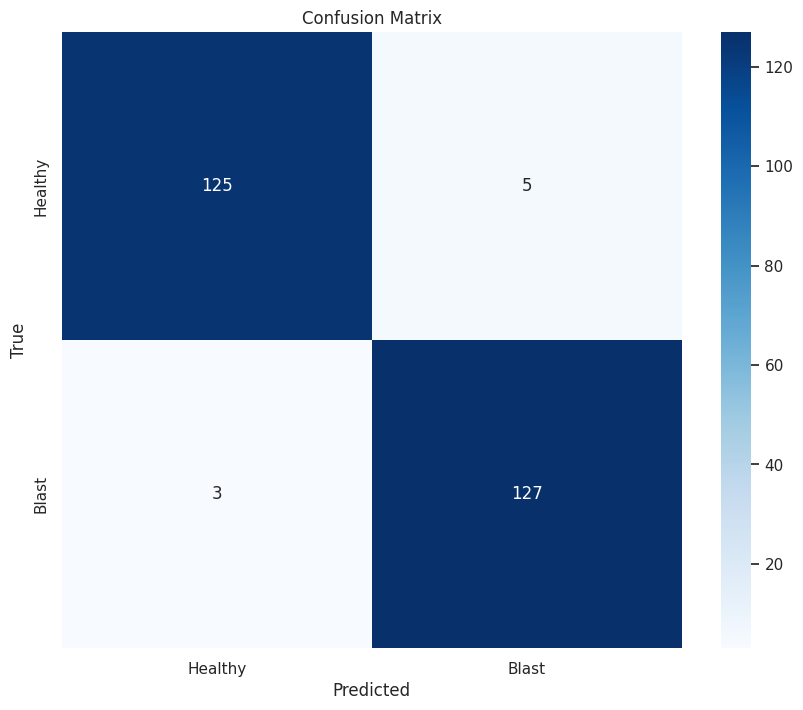

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['Healthy', 'Blast'])


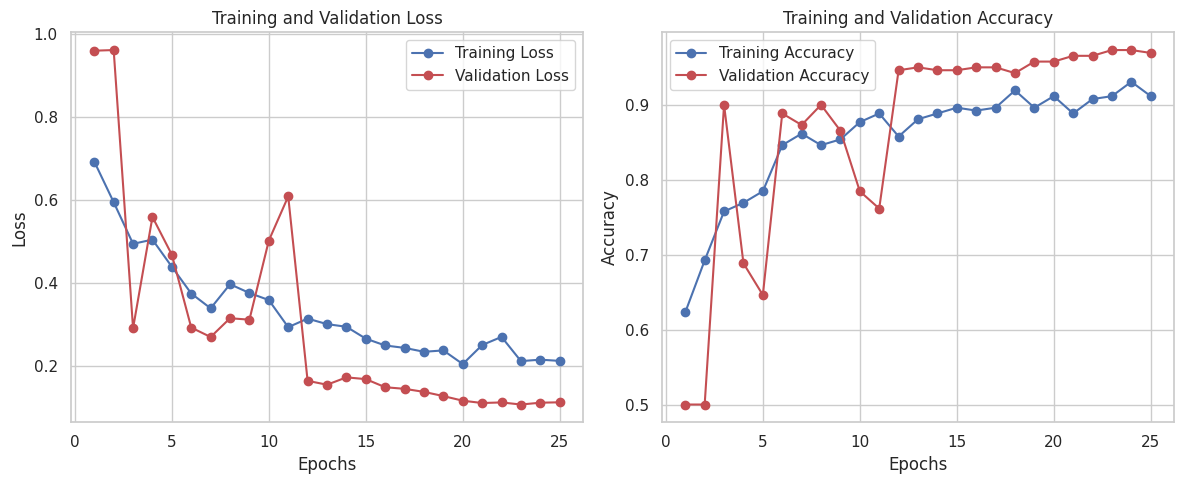

In [10]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


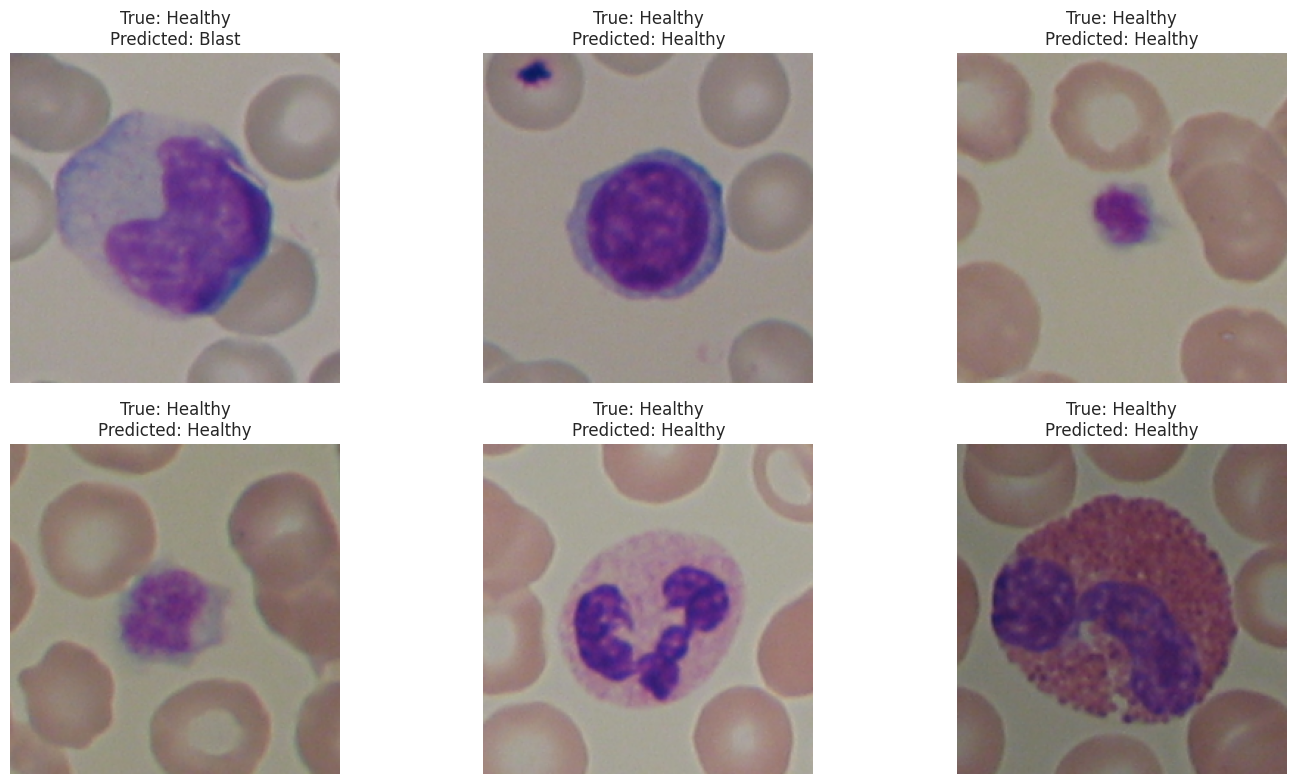

In [11]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Display each image with true and predicted labels
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)  # Un-normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['Healthy', 'Blast'], num_images=6)

